In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import os
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import stop_words

import lda


In [2]:
# max rows and columns
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
# display all contents in dataframe
pd.option_context("display.max_colwidth", -1, "display.max_rows", None)

In [3]:
df = pd.DataFrame()
for file in os.listdir("../data/"):
    df = pd.concat([df, pd.read_csv("../data/"+file)], axis=0)
    print(df.shape)

(54725, 4)
(119136, 4)
(299763, 4)
(372762, 4)


In [4]:
df.head()

,subreddit,created_utc,body,score
0,HeadphoneAdvice,1582863277,[PA] Upgrade from HyperX cloud 2's.I have been...,1
1,HeadphoneAdvice,1582861607,"Neutral, USB stick style DAC, $100-200 range. ...",1
2,HeadphoneAdvice,1582861178,Sennheiser HD 4.5 BTNC vs JBL Live 650BTNCLook...,1
3,HeadphoneAdvice,1582860649,Best General Use IEMS under 200?I've been look...,1
4,HeadphoneAdvice,1582860625,What gaming headphones should I buy?I have use...,1


In [5]:
df.isnull().sum()

subreddit        0
created_utc      0
body           754
score            0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df['year'] = [datetime.fromtimestamp(utc).year for utc in df['created_utc']]
df['month'] = [datetime.fromtimestamp(utc).month for utc in df['created_utc']]

In [8]:
df['year_month'] = df['year'].map(str) + '-' + df['month'].map(str)
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m').dt.strftime('%Y-%m')

In [9]:
df.drop(columns=['created_utc'], axis=1, inplace=True)

In [10]:
df['subreddit'].unique()

array(['HeadphoneAdvice', 'headphones'], dtype=object)

In [11]:
df[df['subreddit']!='HeadphoneAdvice']['year'].unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010],
      dtype=int64)

In [12]:
df['label'] = df['subreddit'].map({'HeadphoneAdvice': 0, 'headphones': 1})

In [13]:
df.head()

,subreddit,body,score,year,month,year_month,label
0,HeadphoneAdvice,[PA] Upgrade from HyperX cloud 2's.I have been...,1,2020,2,2020-02,0
1,HeadphoneAdvice,"Neutral, USB stick style DAC, $100-200 range. ...",1,2020,2,2020-02,0
2,HeadphoneAdvice,Sennheiser HD 4.5 BTNC vs JBL Live 650BTNCLook...,1,2020,2,2020-02,0
3,HeadphoneAdvice,Best General Use IEMS under 200?I've been look...,1,2020,2,2020-02,0
4,HeadphoneAdvice,What gaming headphones should I buy?I have use...,1,2020,2,2020-02,0


#### Plots

In [32]:
df_count = df.pivot_table(index='year', aggfunc='count')[['body']]
df_count.drop(index=[2010, 2020], inplace=True)
df_count

,body
year,
2011,627
2012,6191
2013,10867
2014,16553
2015,22675
2016,26189
2017,25990
2018,98473
2019,141066


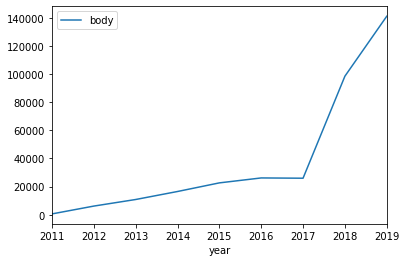

In [41]:
df_count.plot()

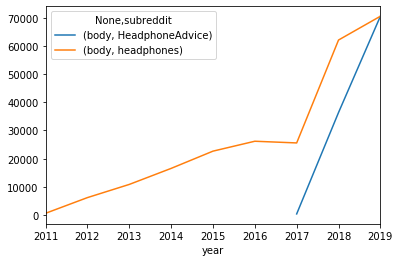

In [39]:
df.pivot_table(index='year', columns='subreddit', aggfunc='count')[['body']].drop(index=[2010, 2020]).plot()

### Modeling: distinguish subreddits

In [42]:
X = df['body']
y = df['label']

In [43]:
y.value_counts(normalize=True)

1    0.67977
0    0.32023
Name: label, dtype: float64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify=y, random_state=42)

#### Pipeline and Gridsearch

In [17]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='liblinear'))
])

In [18]:
pipe_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000], 
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1, 2), (1, 3)]
}

In [19]:
gs = GridSearchCV(pipe, pipe_params, cv=3)

In [20]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [21]:
gs.best_score_

0.7885133101967943

In [22]:
gs.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

In [23]:
pipe_params = {
    'tvec__max_features': [10000, 20000], 
    'tvec__min_df': [5, 10],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1, 2)]
}
gs = GridSearchCV(pipe, pipe_params, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [24]:
gs.best_score_, gs.best_params_

(0.7944432185199302,
 {'tvec__max_df': 0.9,
  'tvec__max_features': 20000,
  'tvec__min_df': 5,
  'tvec__ngram_range': (1, 2)})

#### Modeling : Logistic Regression, Random Forest

In [61]:
tvec = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9, max_features=20000, stop_words='english')
X_train_tvec = tvec.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train_tvec.toarray(), columns=tvec.get_feature_names())
X_train_df.head()

,00,000,000 hz,007,009,009s,01,02,03,04,05,059,06,07,08,09,0a,0db,0s,10,10 000,10 10,10 15,10 20,10 band,10 bucks,10 hours,10 minutes,10 pc,10 pro,10 seconds,10 times,10 years,100,100 100,100 120,100 130,100 150,100 200,100 250,100 300,100 amazon,100 amp,100 better,100 bucks,100 budget,100 cad,100 cheaper,100 currently,100 dac,100 db,100 dollar,100 dollars,100 don,100 euro,100 euros,100 good,100 headphone,100 headphones,100 hello,100 hi,100 iems,100 just,100 like,100 looking,100 mark,100 max,100 need,100 pair,100 possible,100 preferably,100 price,100 range,100 really,100 removed,100 source,100 stretch,100 sure,100 thanks,100 time,100 usd,100 use,100 ve,100 volume,100 want,100 willing,100 worth,1000,1000 xm3,1000mx3,1000x,1000x m3,1000xm2,1000xm3,1000xm3 best,1000xm3 bose,1000xm3 headphones,1000xm3 ve,1000xm3 vs,1000xm3 wireless,1000xm3i,1000xm3s,100hz,100i,100s,100usd,101,105,106,1060c,109,10k,10khz,10s,10th,10x,11,11 11,11 neo,110,110 db,1100,115,119,11e9,12,12 hours,120,1200,125,1266,128,129,13,130,1300,135,139,14,140,145,149,15,15 20,15 minutes,15 years,150,150 200,150 250,150 300,150 amazon,150 better,150 budget,150 cad,150 dollar,150 dollars,150 euros,150 good,150 headphones,150 looking,150 max,150 ohm,150 ohms,150 price,150 range,150 source,150 thanks,150 usd,150 willing,1500,150i,150ish,150ohm,150ohms,150usd,1540,155,159,16,16 44,16 bit,16 ohms,160,1600,165,169,16bit,16k,17,170,175,1770,1770 pro,177x,18,180,1840,185,19,190,192,192khz,195,199,1990,1990 pro,1990 pros,1990s,1a,1am2,1db,1k,1khz,1more,1more quad,1more stylish,1more triple,1s,1st,1st gen,1x,20,20 25,20 30,20 40,20 amp,20 bucks,20 dollars,20 hours,20 https,20 hz,20 minutes,20 years,200,200 250,200 300,200 350,200 400,200 500,200 amp,200 aud,200 bucks,200 budget,200 cad,200 currently,200 dollar,200 dollars,200 euro,200 euros,200 headphones,200 like,200 looking,200 max,200 maybe,200 pair,200 preferably,200 price,200 range,200 really,200 source,200 thanks,200 usd,200 ve,200 willing,200 worth,2000,2000s,200cad,200i,200ish,200usd,201,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,202,2020,20error,20hz,20khz,20removal,20removal 20error,20s,21,210,215,215s,22,220,225,23,230,24,24 96,24 bit,24 hours,240,24bit,25,250,250 300,250 cad,250 looking,250 ohm,250 ohms,250 range,250 source,250 usd,250ohm,250ohms,256,25s,26,260,27,270,275,28,280,280 pro,280 pros,280s,29,29 pdf,290,299,2c,2caps,2db,2f,2f 2fwww,2fwww,2i,2i2,2i4,2k,2khz,2m,2nd,2nd gen,2nd hand,2nd pair,2pin,2s,2u,2v,2x,30,30 40,30 50,30 bucks,30 day,30 days,30 dollars,30 hours,30 minutes,30 seconds,300,300 350,300 400,300 500,300 amp,300 budget,300 cad,300 dollar,300 dollars,300 euros,300 headphones,300 ii,300 looking,300 max,300 ohm,300 ohms,300 pair,300 price,300 range,300 source,300 thanks,300 usd,3000,300i,300ohm,300ohms,300s,300usd,30hz,31,3100,32,32 80,32 bit,32 ohm,32 ohms,320,320 kbps,320kbps,320kbps mp3,325,32bit,32ohm,32ohms,33,330,336se,34,349,35,35 ii,35 word,350,350 400,350 cad,350 usd,353x,35ii,35mm,35s,35x,36,360,363d,37,370,371,373d,375,38,380,380 pro,39,399,3a,3a 2f,3d,3d audio,3d printed,3d sound,3db,3k,3khz,3m,3mm,3rd,3rd gen,3rd party,3s,3x,40,40 50,40 60,40 bt,40 bucks,400,400 500,400 budget,400 range,400 source,400 usd,4000,400i,400s,404,40bt,40mm,40s,40x,42,420,43,44,44 1khz,440,45,450,46,47,470,48,48khz,49,4ghz,4k,4khz,4mm,4s,4th,4x,4xx,4z,50,50 100,50 150,...,wondering experience,wondering good,wondering guys,wondering headphones,wondering help,wondering just,wondering knew,wondering knows,wondering need,wondering options,wondering people,wondering recommendations,wondering sound,wondering suggestions,wondering use,wondering way,wondering worth,wonders,wonky,wont,woo,wood,wooden,word,word comment,wordpress,wordpress com,words,wore,work,work amp,work android,work anymore,work best,work better,work bluetooth,work calls,work computer,work day,work does,work don,work fine,work gaming,work good,work great,work gym,work headphones,work home,work iphone,work just,work laptop,work like,work lis

In [62]:
X_test_tvec = tvec.transform(X_test)

In [63]:
lr = LogisticRegression()
lr.fit(X_train_tvec, y_train)

C:\Users\jjing\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
lr.score(X_train_tvec, y_train), lr.score(X_test_tvec, y_test)

(0.7756734452038851, 0.7241149682075958)

In [75]:
lr.coef_

array([[ 0.75235539, -0.17769773, -0.02730296, ...,  0.079362  ,
        -0.28972017,  1.81000693]])

In [76]:
lr_result = pd.DataFrame()
lr_result['features'] = X_train_df.columns
lr_result['importance'] = lr.coef_[0]
lr_imp = lr_result.sort_values(by='importance', ascending=False)
lr_imp.reset_index(drop=True, inplace = True)

In [79]:
lr_imp = lr_imp[0:30]

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text yticklabel objects>)

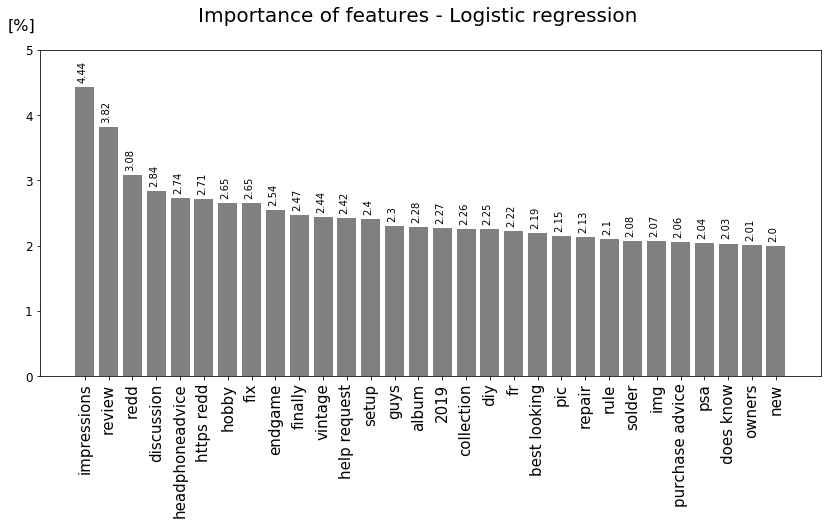

In [87]:
# Draw a barchart of performance of models
fig = plt.figure(figsize = (14, 6))
plt.bar(lr_imp['features'], lr_imp['importance'], color = 'gray')
plt.xticks(rotation=90)
plt.ylim(0, 5)

for width, height in enumerate(lr_imp['importance']):
    plt.text(width-0.3, height + 0.1, round(height, 2), rotation=90)

fig.suptitle('Importance of features - Logistic regression', fontsize=20)
# plt.xlabel('[Model]', fontsize=16, position=(0.95,100))
plt.ylabel('[%]', fontsize=16, rotation=0, position=(0,1.05));
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
# fig.savefig('../img/feature_importance_ozone_utah.png');

In [65]:
rf = RandomForestClassifier(random_state=42, max_depth= 20, n_estimators= 100)
rf.fit(X_train_tvec, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [66]:
rf.score(X_train_tvec, y_train), rf.score(X_test_tvec, y_test)

(0.6994942548193919, 0.6660723492008936)

#### Importance of features

In [67]:
df_result = pd.DataFrame()
df_result['features'] = X_train_df.columns
df_result['importance'] = rf.feature_importances_
df_imp = df_result.sort_values(by='importance', ascending=False)
df_imp.reset_index(drop=True, inplace = True)

In [68]:
df_imp = df_imp[0:30]

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text yticklabel objects>)

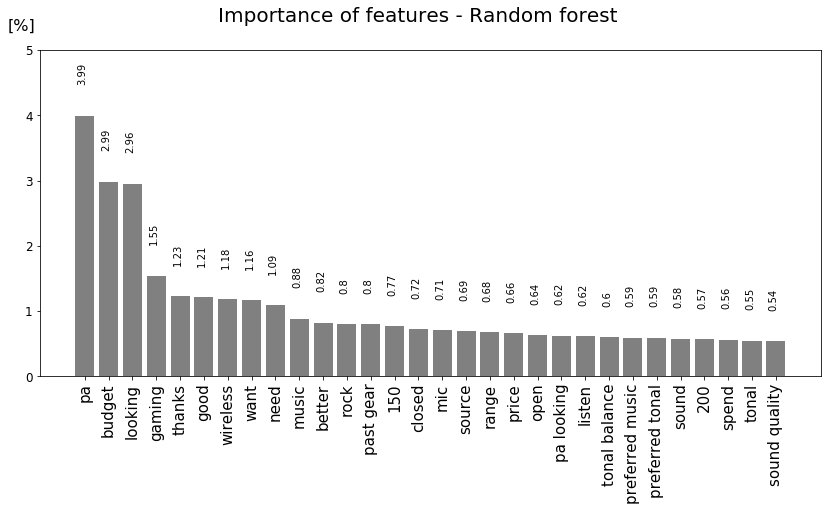

In [88]:
# Draw a barchart of performance of models
fig = plt.figure(figsize = (14, 6))
plt.bar(df_imp['features'], df_imp['importance'] * 100, color = 'gray')
plt.xticks(rotation=90)
plt.ylim(0, 5)

for width, height in enumerate(df_imp['importance']):
    plt.text(width-0.3, height * 100 + 0.5, round(height * 100, 2), rotation=90)

fig.suptitle('Importance of features - Random forest', fontsize=20)
# plt.xlabel('[Model]', fontsize=16, position=(0.95,100))
plt.ylabel('[%]', fontsize=16, rotation=0, position=(0,1.05));
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
# fig.savefig('../img/feature_importance_ozone_utah.png');

### Modeling with only 2019 postings

In [14]:
X = df[df['year']==2019]['body']
y = df[df['year']==2019]['label']

In [15]:
y.value_counts()

1    70538
0    70528
Name: label, dtype: int64

In [16]:
y.value_counts(normalize=True)

1    0.500035
0    0.499965
Name: label, dtype: float64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify=y, random_state=42)

#### Modeling : Logistic Regression, Random Forest

In [18]:
tvec = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9, max_features=20000, stop_words='english')
X_train_tvec = tvec.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train_tvec.toarray(), columns=tvec.get_feature_names())
X_train_df.head()

,00,000,000 hz,007,009,009s,01,02,03,04,05,059,06,07,08,09,0a,0db,0s,10,10 000,10 10,10 15,10 20,10 band,10 bucks,10 hours,10 minutes,10 pc,10 pro,10 seconds,10 times,10 years,100,100 100,100 120,100 130,100 150,100 200,100 250,100 300,100 amazon,100 amp,100 better,100 bucks,100 budget,100 cad,100 cheaper,100 currently,100 dac,100 db,100 dollar,100 dollars,100 don,100 euro,100 euros,100 good,100 headphone,100 headphones,100 hello,100 hi,100 iems,100 just,100 like,100 looking,100 mark,100 max,100 need,100 pair,100 possible,100 preferably,100 price,100 range,100 really,100 removed,100 source,100 stretch,100 sure,100 thanks,100 time,100 usd,100 use,100 ve,100 volume,100 want,100 willing,100 worth,1000,1000 xm3,1000mx3,1000x,1000x m3,1000xm2,1000xm3,1000xm3 best,1000xm3 bose,1000xm3 headphones,1000xm3 ve,1000xm3 vs,1000xm3 wireless,1000xm3i,1000xm3s,100hz,100i,100s,100usd,101,105,106,1060c,109,10k,10khz,10s,10th,10x,11,11 11,11 neo,110,110 db,1100,115,119,11e9,12,12 hours,120,1200,125,1266,128,129,13,130,1300,135,139,14,140,145,149,15,15 20,15 minutes,15 years,150,150 200,150 250,150 300,150 amazon,150 better,150 budget,150 cad,150 dollar,150 dollars,150 euros,150 good,150 headphones,150 looking,150 max,150 ohm,150 ohms,150 price,150 range,150 source,150 thanks,150 usd,150 willing,1500,150i,150ish,150ohm,150ohms,150usd,1540,155,159,16,16 44,16 bit,16 ohms,160,1600,165,169,16bit,16k,17,170,175,1770,1770 pro,177x,18,180,1840,185,19,190,192,192khz,195,199,1990,1990 pro,1990 pros,1990s,1a,1am2,1db,1k,1khz,1more,1more quad,1more stylish,1more triple,1s,1st,1st gen,1x,20,20 25,20 30,20 40,20 amp,20 bucks,20 dollars,20 hours,20 https,20 hz,20 minutes,20 years,200,200 250,200 300,200 350,200 400,200 500,200 amp,200 aud,200 bucks,200 budget,200 cad,200 currently,200 dollar,200 dollars,200 euro,200 euros,200 headphones,200 like,200 looking,200 max,200 maybe,200 pair,200 preferably,200 price,200 range,200 really,200 source,200 thanks,200 usd,200 ve,200 willing,200 worth,2000,2000s,200cad,200i,200ish,200usd,201,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,202,2020,20error,20hz,20khz,20removal,20removal 20error,20s,21,210,215,215s,22,220,225,23,230,24,24 96,24 bit,24 hours,240,24bit,25,250,250 300,250 cad,250 looking,250 ohm,250 ohms,250 range,250 source,250 usd,250ohm,250ohms,256,25s,26,260,27,270,275,28,280,280 pro,280 pros,280s,29,29 pdf,290,299,2c,2caps,2db,2f,2f 2fwww,2fwww,2i,2i2,2i4,2k,2khz,2m,2nd,2nd gen,2nd hand,2nd pair,2pin,2s,2u,2v,2x,30,30 40,30 50,30 bucks,30 day,30 days,30 dollars,30 hours,30 minutes,30 seconds,300,300 350,300 400,300 500,300 amp,300 budget,300 cad,300 dollar,300 dollars,300 euros,300 headphones,300 ii,300 looking,300 max,300 ohm,300 ohms,300 pair,300 price,300 range,300 source,300 thanks,300 usd,3000,300i,300ohm,300ohms,300s,300usd,30hz,31,3100,32,32 80,32 bit,32 ohm,32 ohms,320,320 kbps,320kbps,320kbps mp3,325,32bit,32ohm,32ohms,33,330,336se,34,349,35,35 ii,35 word,350,350 400,350 cad,350 usd,353x,35ii,35mm,35s,35x,36,360,363d,37,370,371,373d,375,38,380,380 pro,39,399,3a,3a 2f,3d,3d audio,3d printed,3d sound,3db,3k,3khz,3m,3mm,3rd,3rd gen,3rd party,3s,3x,40,40 50,40 60,40 bt,40 bucks,400,400 500,400 budget,400 range,400 source,400 usd,4000,400i,400s,404,40bt,40mm,40s,40x,42,420,43,44,44 1khz,440,45,450,46,47,470,48,48khz,49,4ghz,4k,4khz,4mm,4s,4th,4x,4xx,4z,50,50 100,50 150,...,wondering experience,wondering good,wondering guys,wondering headphones,wondering help,wondering just,wondering knew,wondering knows,wondering need,wondering options,wondering people,wondering recommendations,wondering sound,wondering suggestions,wondering use,wondering way,wondering worth,wonders,wonky,wont,woo,wood,wooden,word,word comment,wordpress,wordpress com,words,wore,work,work amp,work android,work anymore,work best,work better,work bluetooth,work calls,work computer,work day,work does,work don,work fine,work gaming,work good,work great,work gym,work headphones,work home,work iphone,work just,work laptop,work like,work lis

In [19]:
X_test_tvec = tvec.transform(X_test)

In [20]:
lr = LogisticRegression()
lr.fit(X_train_tvec, y_train)

C:\Users\jjing\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
lr.score(X_train_tvec, y_train), lr.score(X_test_tvec, y_test)

(0.7756734452038851, 0.7241149682075958)

In [58]:
rf = RandomForestClassifier(random_state=42, max_depth= 40, n_estimators= 100)
rf.fit(X_train_tvec, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [59]:
rf.score(X_train_tvec, y_train), rf.score(X_test_tvec, y_test)

(0.7880948854138011, 0.6810448530675374)

#### Importance of features

In [45]:
df_result = pd.DataFrame()
df_result['features'] = X_train_df.columns
df_result['importance'] = rf.feature_importances_
df_imp = df_result.sort_values(by='importance', ascending=False)
df_imp.reset_index(drop=True, inplace = True)

In [46]:
df_imp = df_imp[0:30]

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text yticklabel objects>)

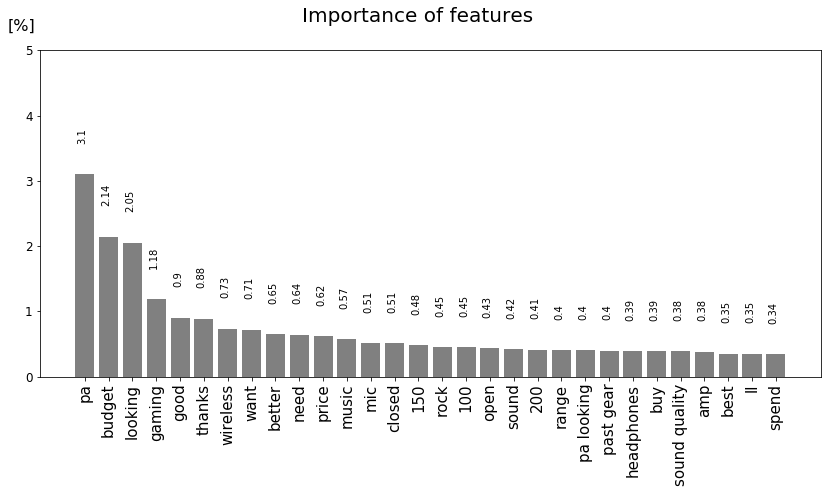

In [55]:
# Draw a barchart of performance of models
fig = plt.figure(figsize = (14, 6))
plt.bar(df_imp['features'], df_imp['importance'] * 100, color = 'gray')
plt.xticks(rotation=90)
plt.ylim(0, 5)

for width, height in enumerate(df_imp['importance']):
    plt.text(width-0.3, height * 100 + 0.5, round(height * 100, 2), rotation=90)

fig.suptitle('Importance of features', fontsize=20)
# plt.xlabel('[Model]', fontsize=16, position=(0.95,100))
plt.ylabel('[%]', fontsize=16, rotation=0, position=(0,1.05));
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
# fig.savefig('../img/feature_importance_ozone_utah.png');

In [54]:
round(3/2)

2